## Importing essential libraries

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.initializers import glorot_uniform
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Input
from keras.optimizers import Adam


## Loading the data set

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
folder_path = '/content/drive/My Drive/Alzheimer_s_Disease_Neuroimaging_ADNI_Dataset'

## Preproccesing and augmentation

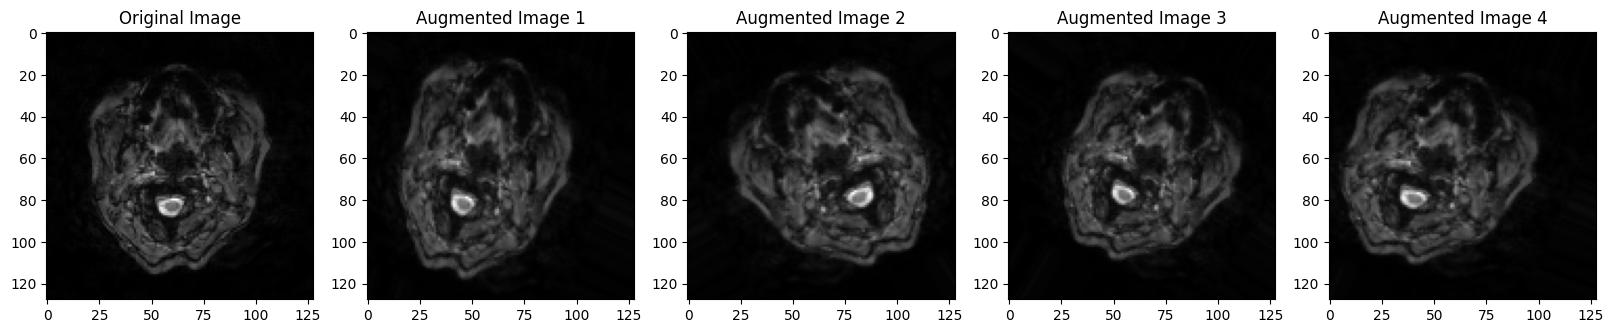

Finished processing images for label 'MCI'.
Number of images for label 'MCI': 3445
Finished processing images for label 'AD'.
Number of images for label 'AD': 4825
There are 8270 images in the 'images' variable.
There are 8270 image labels in the 'image_labels' variable.
There are 2 unique labels in the 'image_labels_encoded' variable.
The unique labels are: [0 1]
The counts of each label are: [4825 3445]


In [4]:
image_dir = folder_path

labels = ["MCI", "AD"]

image_size = (128, 128)

rescale = 1./255

augmentation_params = dict(horizontal_flip=True, shear_range=0.2, height_shift_range=0.1, rotation_range=45, zoom_range=[0.9, 1.1])

images = []
image_labels = []

datagen = ImageDataGenerator(**augmentation_params)

first_image = True

for label in labels:

    for filename in os.listdir(os.path.join(image_dir, label)):

        img = cv2.imread(os.path.join(image_dir, label, filename), cv2.IMREAD_GRAYSCALE)

        img = cv2.resize(img, image_size)

        img = img * rescale

        img_4d = img.reshape((1,) + img.shape + (1,))

        i = 0
        for batch in datagen.flow(img_4d, batch_size=1):

            images.append(batch[0])
            image_labels.append(label)
            i += 1
            if i >= 5:
                break

        if first_image:
            plt.figure(figsize=(20, 10))
            plt.subplot(1, 5, 1)
            plt.imshow(img, cmap='gray')
            plt.title('Original Image')
            for j in range(4):
                plt.subplot(1, 5, j+2)
                plt.imshow(images[j].reshape(image_size), cmap='gray')
                plt.title(f'Augmented Image {j+1}')
            plt.show()
            first_image = False
    print(f"Finished processing images for label '{label}'.")
    print(f"Number of images for label '{label}': {image_labels.count(label)}")



# Convert the lists to numpy arrays
images = np.array(images)
image_labels = np.array(image_labels)

print(f"There are {len(images)} images in the 'images' variable.")

# Convert labels to integers then one-hot encode
encoder = LabelEncoder()
image_labels_encoded = encoder.fit_transform(image_labels)
image_labels_categorical = to_categorical(image_labels_encoded)

print(f"There are {len(image_labels)} image labels in the 'image_labels' variable.")

# Now, print the unique labels and their counts
unique_labels, counts = np.unique(image_labels_encoded, return_counts=True)
print(f"There are {len(unique_labels)} unique labels in the 'image_labels_encoded' variable.")
print("The unique labels are:", unique_labels)
print("The counts of each label are:", counts)

## Splitting the data
**Split the data into training and testing sets (50% training, 50% testing)**

**Further split the training data into training and validation sets (90% training, 10% validation)**

In [5]:
X_train, X_test, y_train, y_test = train_test_split(images, image_labels_categorical, test_size=0.5, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)


## Defining and compiling the proposed model, model_test1, model_test2

In [6]:
from keras.losses import CategoricalCrossentropy

# Define the optimizer with learning rate 0.001
optimizer = Adam(learning_rate=0.001)

# Define the Glorot uniform initializer
initializer = glorot_uniform(seed=42)

# Define the model
model_proposed = Sequential([
    Input(shape=(128, 128, 1)),
    Conv2D(32, (3, 3), activation='relu', kernel_initializer=initializer),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', kernel_initializer=initializer),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(32, (3, 3), activation='relu', kernel_initializer=initializer),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', kernel_initializer=initializer),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu', kernel_initializer=initializer),
    Dense(64, activation='relu', kernel_initializer=initializer),
    Dense(2, activation='softmax', kernel_initializer=initializer)  # Set number of units to 2 for two classes
])

model_proposed.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])


In [7]:
model_proposed.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      320       
                                                                 
 batch_normalization (Batch  (None, 126, 126, 32)      128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 32)      9248      
                                                                 
 batch_normalization_1 (Bat  (None, 124, 124, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 62, 62, 32)        0         
 D)                                                              
                                                        

##Fitting and executing the Proposed model ( batch_size = 64 )


## Adding dropout to the model and analysing it

In [8]:
from keras.layers import Dropout

# Define the Proposed model with dropout
model_proposed_dropout = Sequential([
    Input(shape=(128, 128, 1)),
    Conv2D(32, (3, 3), activation='relu', kernel_initializer=initializer),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', kernel_initializer=initializer),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),  # Added dropout
    Conv2D(32, (3, 3), activation='relu', kernel_initializer=initializer),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', kernel_initializer=initializer),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),  # Added dropout
    Flatten(),
    Dense(128, activation='relu', kernel_initializer=initializer),
    Dropout(0.5),  # Added dropout
    Dense(64, activation='relu', kernel_initializer=initializer),
    Dropout(0.5),  # Added dropout
    Dense(2, activation='softmax', kernel_initializer=initializer)  # Set number of units to 2 for two classes
])

# Use the legacy Adam optimizer
model_proposed_dropout.compile(optimizer=tf.keras.optimizers.legacy.Adam(), loss=CategoricalCrossentropy(), metrics=['accuracy'])

# Now you can fit the model
history_proposed_dropout = model_proposed_dropout.fit(X_train, y_train, batch_size=64, validation_data=(X_val, y_val), epochs=20)


Epoch 1/20
59/59 [==============================] - 14s 119ms/step - loss: 2.0397 - accuracy: 0.5614 - val_loss: 2.0692 - val_accuracy: 0.5894
Epoch 2/20
59/59 [==============================] - 6s 97ms/step - loss: 0.6887 - accuracy: 0.5904 - val_loss: 3.0191 - val_accuracy: 0.5894
Epoch 3/20
59/59 [==============================] - 6s 97ms/step - loss: 0.6738 - accuracy: 0.5899 - val_loss: 4.3184 - val_accuracy: 0.5894
Epoch 4/20
59/59 [==============================] - 6s 97ms/step - loss: 0.6711 - accuracy: 0.5886 - val_loss: 0.9624 - val_accuracy: 0.5483
Epoch 5/20
59/59 [==============================] - 6s 98ms/step - loss: 0.6666 - accuracy: 0.5880 - val_loss: 0.8227 - val_accuracy: 0.5845
Epoch 6/20
59/59 [==============================] - 6s 98ms/step - loss: 0.6667 - accuracy: 0.5912 - val_loss: 1.7419 - val_accuracy: 0.5845
Epoch 7/20
59/59 [==============================] - 6s 100ms/step - loss: 0.6708 - accuracy: 0.5910 - val_loss: 0.7228 - val_accuracy: 0.5942
Epoch 8/20

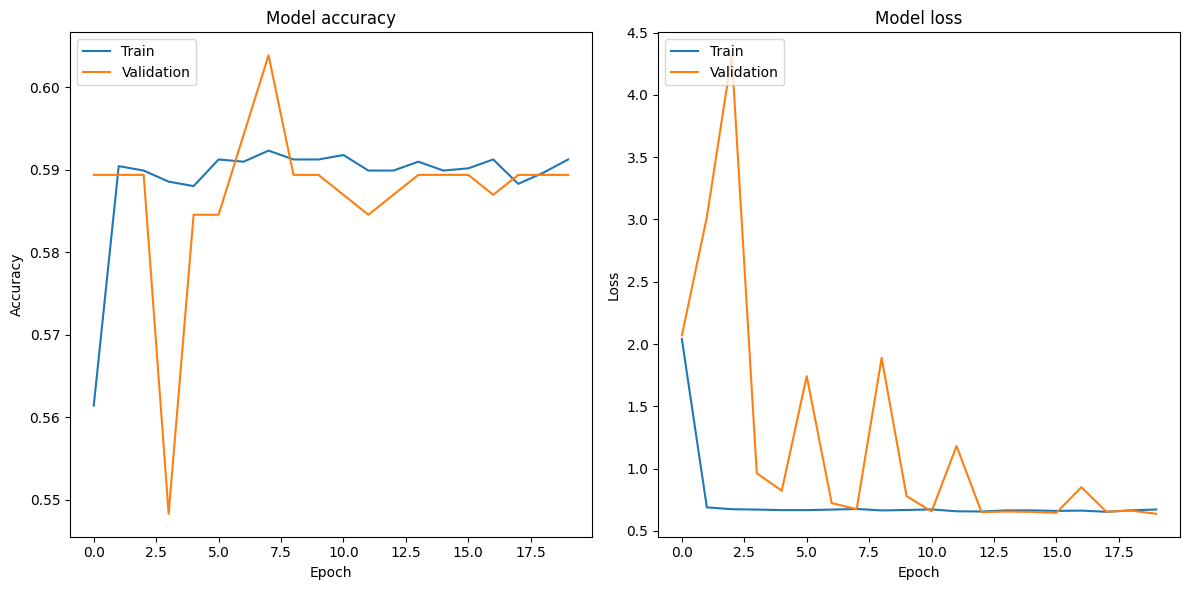

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_proposed_dropout.history['accuracy'])
plt.plot(history_proposed_dropout.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_proposed_dropout.history['loss'])
plt.plot(history_proposed_dropout.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

## ROC curve

130/130 [==============================] - 2s 10ms/step


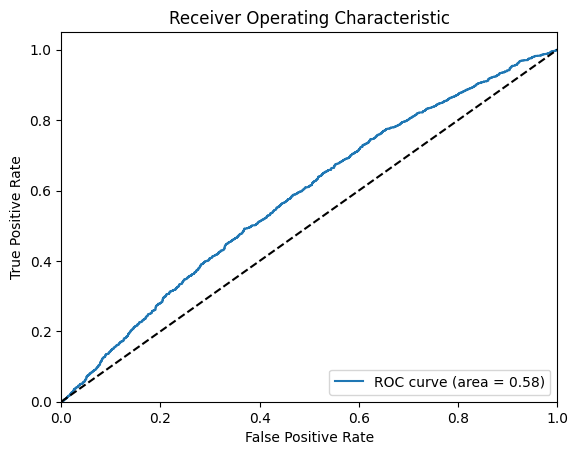

In [10]:
y_pred_prob = model_proposed.predict(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):  # number of classes
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve
plt.figure()
plt.plot(fpr[1], tpr[1], label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


## Analysing the model

In [11]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from keras.metrics import Precision, Recall

y_pred_prob = model_proposed.predict(X_test)

y_pred_class = np.argmax(y_pred_prob, axis=1)


cm = confusion_matrix(y_test.argmax(axis=1), y_pred_class)

cr = classification_report(y_test.argmax(axis=1), y_pred_class, target_names=['AD', 'MCI'])

auc = roc_auc_score(y_test, model_proposed.predict(X_test))

print("Confusion Matrix:")
print(cm)

print("Classification Report:")
print(cr)

print("AUC: ", auc)


130/130 [==============================] - 1s 7ms/step
Confusion Matrix:
[[1828  551]
 [1192  564]]
Classification Report:
              precision    recall  f1-score   support

          AD       0.61      0.77      0.68      2379
         MCI       0.51      0.32      0.39      1756

    accuracy                           0.58      4135
   macro avg       0.56      0.54      0.54      4135
weighted avg       0.56      0.58      0.56      4135

AUC:  0.5806769153211327
